In [1]:
import numpy as np 
import sys
import pdb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
import random

In [2]:
def get_data(x_path, y_path):
    '''
    Args:
        x_path: path to x file
        y_path: path to y file
    Returns:
        x: np array of [NUM_OF_SAMPLES x n]
        y: np array of [NUM_OF_SAMPLES]
    '''
    x = np.load(x_path)
    y = np.load(y_path)

    y = y.astype('float')
    x = x.astype('float')

    #normalize x:
    x = 2*(0.5 - x/255)
    return x, y

In [3]:
def get_metric(y_true, y_pred):
    '''
    Args:
        y_true: np array of [NUM_SAMPLES x r] (one hot) 
                or np array of [NUM_SAMPLES]
        y_pred: np array of [NUM_SAMPLES x r] (one hot) 
                or np array of [NUM_SAMPLES]
                
    '''
    results = classification_report(y_pred, y_true)
    print(results)

##### Preparing the X_train, y_train, X_test, y_test

In [4]:
x_train_path = "/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 3/Data_b/x_train.npy"
y_train_path = "/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 3/Data_b/y_train.npy"

X_train, y_train = get_data(x_train_path, y_train_path)

x_test_path = "/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 3/Data_b/x_test.npy"
y_test_path = "/home/tkarthikeyan/IIT Delhi/COL774-Machine Learning/Assignment 3/Data_b/y_test.npy"

X_test, y_test = get_data(x_test_path, y_test_path)

#you might need one hot encoded y in part a,b,c,d,e
label_encoder = OneHotEncoder(sparse_output = False)
label_encoder.fit(np.expand_dims(y_train, axis = -1))

y_train_onehot = label_encoder.transform(np.expand_dims(y_train, axis = -1))
y_test_onehot = label_encoder.transform(np.expand_dims(y_test, axis = -1))

In [5]:
class NeuralNetwork:
    def __init__(self, n, n_hidden_nodes, r, M):
        #Number of nodes in the architecture
        self.n = n
        self.n_hidden_nodes = n_hidden_nodes
        self.r = r
        
        #Mini batch size
        self.M = M
        
        #Weights and biases
        self.W = dict()
        self.b = dict()
        
    def initialize_weights_and_biases(self):
        n_nodes = [self.n] + self.n_hidden_nodes + [self.r]
        
        #Initialize weights
        for i in range(1,len(n_nodes)):
            self.W[str(i)] = np.random.uniform(low=-0.1, high=0.1, size=(n_nodes[i], n_nodes[i-1]))
        
        #Initialize biases
        for i in range(1,len(n_nodes)):
            self.b[str(i)] = np.zeros((n_nodes[i],1))
     
    @staticmethod
    def sigmoid(x, derivative = False):
        if derivative == False:
            return 1 / (1 + np.exp(-x))
        else:
            return NeuralNetwork.sigmoid(x, derivative = False) * (1 - NeuralNetwork.sigmoid(x, derivative = False))
    
    @staticmethod
    def relu(x, derivative = False):
        if derivative == True:
            return np.where(x > 0, 1, np.where(x < 0, 0, np.random.random_sample()))
        else:
            return np.where(x <= 0, 0, x)
    
    @staticmethod
    def softmax(Z):
        return np.exp(Z) / np.sum(np.exp(Z), axis=0)

    def train(self, X_train, y_train, epoch_mode = True, activation="sigmoid", EPOCHS = 200, alpha = 0.01, stopping_threshold = None, adaptive_learning=False, printafter=20):
        self.initialize_weights_and_biases()
        
        a = dict()
        z = dict()
        del_z = dict()
        del_b = dict()
        del_W = dict()
        
        if epoch_mode == True:
            for epoch in range(EPOCHS):
                for i in range(0, X_train.shape[0], self.M):
                    y_actual = y_train[i:i+self.M,:].T
                    
                    #Forward
                    a["0"] = X_train[i:i+self.M,:].T
                    
                    for j in range(1,len(self.n_hidden_nodes)+1):
                        z[str(j)] = np.matmul(self.W[str(j)], a[str(j-1)]) + self.b[str(j)]
                        if activation == "relu":
                            a[str(j)] = NeuralNetwork.relu(z[str(j)])
                        else:
                            a[str(j)] = NeuralNetwork.sigmoid(z[str(j)])
                    
                    j += 1
                    z[str(j)] = np.matmul(self.W[str(j)], a[str(j-1)]) + self.b[str(j)]
                    a[str(j)] = NeuralNetwork.softmax(z[str(j)])
                    
                    #Backward
                    del_z[str(j)] = a[str(j)] - y_actual
                    del_b[str(j)] = np.sum(del_z[str(j)], axis = 1).reshape(-1,1)
                    del_W[str(j)] = np.matmul(del_z[str(j)], a[str(j-1)].T)
                    
                    for k in range(j-1,0,-1):
                        if activation == "relu":
                            del_z[str(k)] = np.matmul(self.W[str(k+1)].T, del_z[str(k+1)])*(NeuralNetwork.relu(z[str(k)], derivative=True))
                        else:
                            del_z[str(k)] = np.matmul(self.W[str(k+1)].T, del_z[str(k+1)])*(NeuralNetwork.sigmoid(z[str(k)], derivative=True))
                        del_b[str(k)] = np.sum(del_z[str(k)], axis = 1).reshape(-1,1)
                        del_W[str(k)] = np.matmul(del_z[str(k)], a[str(k-1)].T)
                    
                    #Update
                    for l in range(1,len(self.n_hidden_nodes)+2):
                        if adaptive_learning == False:
                            self.W[str(l)] = self.W[str(l)] - alpha * del_W[str(l)]
                            self.b[str(l)] = self.b[str(l)] - alpha * del_b[str(l)]
                        else:
                            self.W[str(l)] = self.W[str(l)] - (alpha/np.sqrt(epoch)) * del_W[str(l)]
                            self.b[str(l)] = self.b[str(l)] - (alpha/np.sqrt(epoch)) * del_b[str(l)]
                        
                y_pred, softmax_output = NN.predict(X_train, activation=activation)
                softmax_loss = NeuralNetwork.compute_softmax_loss(softmax_output, y_train_onehot)
                if epoch%printafter==0:
                    print(f"epoch {epoch}")
                    print("accuracy on train data: ",accuracy_score(y_train_onehot, y_pred))
                    if adaptive_learning:
                        print("learning rate: ",(alpha/np.sqrt(epoch)))
                    print("softmax loss: ",softmax_loss)
                    print("\n")

        else:
            epoch = 1
            window = 5
            loss_avg = 0
            while(True):
                for i in range(0, X_train.shape[0], self.M):
                    y_actual = y_train[i:i+self.M,:].T
                    
                    #Forward
                    a["0"] = X_train[i:i+self.M,:].T
                    
                    for j in range(1,len(self.n_hidden_nodes)+1):
                        z[str(j)] = np.matmul(self.W[str(j)], a[str(j-1)]) + self.b[str(j)]
                        if activation == "relu":
                            a[str(j)] = NeuralNetwork.relu(z[str(j)])
                        else:
                            a[str(j)] = NeuralNetwork.sigmoid(z[str(j)])
                    
                    j += 1
                    z[str(j)] = np.matmul(self.W[str(j)], a[str(j-1)]) + self.b[str(j)]
                    a[str(j)] = NeuralNetwork.softmax(z[str(j)])
                    
                    #Backward
                    del_z[str(j)] = a[str(j)] - y_actual
                    del_b[str(j)] = np.sum(del_z[str(j)], axis = 1).reshape(-1,1)
                    del_W[str(j)] = np.matmul(del_z[str(j)], a[str(j-1)].T)
                    
                    for k in range(j-1,0,-1):
                        if activation == "relu":
                            del_z[str(k)] = np.matmul(self.W[str(k+1)].T, del_z[str(k+1)])*(NeuralNetwork.relu(z[str(k)], derivative=True))
                        else:
                            del_z[str(k)] = np.matmul(self.W[str(k+1)].T, del_z[str(k+1)])*(NeuralNetwork.sigmoid(z[str(k)], derivative=True))
                        del_b[str(k)] = np.sum(del_z[str(k)], axis = 1).reshape(-1,1)
                        del_W[str(k)] = np.matmul(del_z[str(k)], a[str(k-1)].T)
                    
                    #Update
                    for l in range(1,len(self.n_hidden_nodes)+2):
                        if adaptive_learning == False:
                            self.W[str(l)] = self.W[str(l)] - alpha * del_W[str(l)]
                            self.b[str(l)] = self.b[str(l)] - alpha * del_b[str(l)]
                        else:
                            self.W[str(l)] = self.W[str(l)] - (alpha/np.sqrt(epoch)) * del_W[str(l)]
                            self.b[str(l)] = self.b[str(l)] - (alpha/np.sqrt(epoch)) * del_b[str(l)]
                        
                y_pred, softmax_output = NN.predict(X_train, activation=activation)
                softmax_loss = NeuralNetwork.compute_softmax_loss(softmax_output, y_train_onehot)
                if epoch%printafter==0:
                    print(f"epoch {epoch}")
                    print("accuracy on train data: ",accuracy_score(y_train_onehot, y_pred))
                    if adaptive_learning:
                        print("learning rate: ",(alpha/np.sqrt(epoch)))
                    print("softmax loss: ",softmax_loss)
                    print("\n")
                
                if epoch <= window:
                    loss_avg += softmax_loss
                    if epoch == window:
                        loss_avg /= window
                
                #End the training
                if epoch > window:
                    new_loss_avg = ((window - 1)*loss_avg + softmax_loss)/window
                    diff_avg_loss = abs(new_loss_avg - loss_avg)
                    #print("diff avg loss:",diff_avg_loss)
                    if diff_avg_loss < stopping_threshold or epoch > EPOCHS:
                        print("Convergence criteria satisfied!")
                        print(f"epoch {epoch}")
                        print("accuracy on train data: ",accuracy_score(y_train_onehot, y_pred))
                        if adaptive_learning:
                            print("learning rate: ",(alpha/np.sqrt(epoch)))
                        print("softmax loss: ",softmax_loss)
                        print("\n")
                        break
                
                epoch += 1
                        
    def predict(self, X_test, activation="sigmoid"):
        y_pred = np.zeros((X_test.shape[0], self.r))
        softmax_output = np.zeros((X_test.shape[0], self.r))
        z = dict()
        a = dict()
        
        for i in range(X_test.shape[0]):
            a[str(0)] = X_test[i:i+1,:].T
            
            for j in range(1,len(self.n_hidden_nodes)+1):
                z[str(j)] = np.matmul(self.W[str(j)], a[str(j-1)]) + self.b[str(j)]
                if activation == "relu":
                    a[str(j)] = NeuralNetwork.relu(z[str(j)])
                else:
                    a[str(j)] = NeuralNetwork.sigmoid(z[str(j)])
            
            j += 1
            z[str(j)] = np.matmul(self.W[str(j)], a[str(j-1)]) + self.b[str(j)]
            a[str(j)] = NeuralNetwork.softmax(z[str(j)])
            
            softmax_output[i] = a[str(j)].flatten()
            y_pred[i][np.argmax(a[str(j)])] = 1
            
        return y_pred, softmax_output
    
    @staticmethod
    def compute_softmax_loss(softmax_output, y_pred):
        #Softmax loss
        sm_loss = 0
        for i in range(y_pred.shape[0]):
            sm_loss = -1*np.log2(softmax_output[i][np.argmax(y_pred[i])])
            
        return sm_loss/(y_pred.shape[0])

In [28]:
NN = NeuralNetwork(n = 1024, n_hidden_nodes = [100,50] , r = 5, M = 32)
NN.train(X_train, y_train_onehot, activation="sigmoid", EPOCHS=100, alpha=0.001, printafter=10)
y_pred, softmax_output = NN.predict(X_test, activation="sigmoid")
print("accuracy on test data: ",accuracy_score(y_test_onehot, y_pred))
get_metric(y_test_onehot, y_pred)

epoch 0
accuracy on train data:  0.2091
softmax loss:  0.00023525478839202835


epoch 10
accuracy on train data:  0.5923
softmax loss:  0.00011264389363753989


epoch 20
accuracy on train data:  0.6572
softmax loss:  5.831073565883006e-05


epoch 30
accuracy on train data:  0.6702
softmax loss:  4.656056662492289e-05


epoch 40
accuracy on train data:  0.6758
softmax loss:  3.9645451044889796e-05


epoch 50
accuracy on train data:  0.6803
softmax loss:  3.4488996828750714e-05


epoch 60
accuracy on train data:  0.6869
softmax loss:  3.0593861550354343e-05


epoch 70
accuracy on train data:  0.6908
softmax loss:  2.8066258449785907e-05


epoch 80
accuracy on train data:  0.6976
softmax loss:  2.7373041902283903e-05


epoch 90
accuracy on train data:  0.7037
softmax loss:  2.8412086233645623e-05


accuracy on test data:  0.714
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       224
           1       0.75      0.76      0.76       196


In [34]:
print("f1_score: ",f1_score(y_test_onehot, y_pred, average="macro"))

f1_score:  0.7029924239467376


#### Experimenting with single hidden layer

In [41]:
hidden_layers = [[1],[5],[10],[50],[100]]
number_of_hidden_units = [1,5,10,50,100]
f1_score_train = []
f1_score_test = []
for hidden_layer in hidden_layers:
    print(f"Hidden layer: {hidden_layer}")
    NN = NeuralNetwork(n = 1024, n_hidden_nodes = hidden_layer , r = 5, M = 32)
    NN.train(X_train, y_train_onehot, epoch_mode= False, activation="sigmoid", alpha = 0.01, stopping_threshold = 1.0e-06, printafter=50)
    y_pred_train, _ = NN.predict(X_train)
    y_pred_test, _ = NN.predict(X_test)
    
    print("accuracy on train data: ",accuracy_score(y_train_onehot, y_pred_train))
    print("metrics for train data: ")
    get_metric(y_train_onehot, y_pred_train)
    f1_score_train.append(f1_score(y_train_onehot, y_pred_train, average="macro"))
    
    print("accuracy on test data: ",accuracy_score(y_test_onehot, y_pred_test))
    print("metrics for test data: ")
    get_metric(y_test_onehot, y_pred_test)
    f1_score_test.append(f1_score(y_test_onehot, y_pred_test, average="macro"))
    
    print("\n")

Hidden layer: [1]
epoch 50
accuracy on train data:  0.4706
softmax loss:  0.00014958531153011078


epoch 100
accuracy on train data:  0.2091
softmax loss:  0.00023287816358262217


epoch 150
accuracy on train data:  0.2091
softmax loss:  0.0002328781641601466


epoch 200
accuracy on train data:  0.2091
softmax loss:  0.00023287816494873916


Convergence criteria satisfied!
epoch 201
accuracy on train data:  0.2091
softmax loss:  0.00023287816496746151


accuracy on train data:  0.2091
metrics for train data: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.21      0.35     10000

   micro avg       0.21      0.21      0.21     10000
   macro avg       0.20      0.04      0.07     10000
weighted avg       1.00      0.21      0.35     100

/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 50
accuracy on train data:  0.6775
softmax loss:  5.1494534443521053e-05


epoch 100
accuracy on train data:  0.6858
softmax loss:  3.220427274554847e-05


epoch 150
accuracy on train data:  0.6952
softmax loss:  2.7774495226855474e-05


epoch 200
accuracy on train data:  0.6982
softmax loss:  2.603425353508207e-05


Convergence criteria satisfied!
epoch 201
accuracy on train data:  0.6977
softmax loss:  2.6049241749681784e-05


accuracy on train data:  0.6977
metrics for train data: 
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      2176
           1       0.64      0.77      0.70      1652
           2       0.73      0.56      0.63      2544
           3       0.41      0.56      0.47      1447
           4       0.77      0.73      0.75      2181

   micro avg       0.70      0.70      0.70     10000
   macro avg       0.70      0.70      0.69     10000
weighted avg       0.72      0.70      0.70     10000
 samples avg    

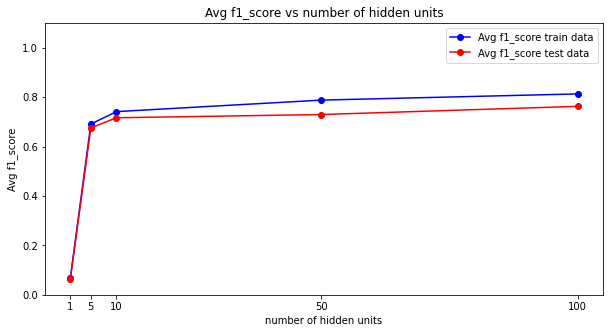

In [43]:
#Plot avg f1_scores for different number of hidden units
plt.figure(figsize=(10,5))
plt.plot(number_of_hidden_units, f1_score_train, marker='o', markersize=6, color='blue', label='Avg f1_score train data')
plt.plot(number_of_hidden_units, f1_score_test, marker='o', markersize=6, color='red', label='Avg f1_score test data')

plt.title('Avg f1_score vs number of hidden units')
plt.xlabel('number of hidden units')
plt.ylabel('Avg f1_score')
plt.xticks(number_of_hidden_units)
plt.ylim(0,1.1)
plt.legend()
plt.show()

#### Experimenting with hidden layers

In [44]:
hidden_layers = [[512], [512,256], [512,256,128], [512,256,128,64]]
network_depth = [1,2,3,4]
f1_score_train = []
f1_score_test = []
for hidden_layer in hidden_layers:
    print(f"Hidden layer: {hidden_layer}")
    NN = NeuralNetwork(n = 1024, n_hidden_nodes = hidden_layer , r = 5, M = 32)
    NN.train(X_train, y_train_onehot, epoch_mode= False, activation="sigmoid", alpha = 0.01, stopping_threshold = 1.0e-06, printafter=50)
    y_pred_train, _ = NN.predict(X_train)
    y_pred_test, _ = NN.predict(X_test)
    
    print("accuracy on train data: ",accuracy_score(y_train_onehot, y_pred_train))
    print("metrics for train data: ")
    get_metric(y_train_onehot, y_pred_train)
    f1_score_train.append(f1_score(y_train_onehot, y_pred_train, average="macro"))
    
    print("accuracy on test data: ",accuracy_score(y_test_onehot, y_pred_test))
    print("metrics for test data: ")
    get_metric(y_test_onehot, y_pred_test)
    f1_score_test.append(f1_score(y_test_onehot, y_pred_test, average="macro"))
    
    print("\n")

Hidden layer: [512]
epoch 50
accuracy on train data:  0.7327
softmax loss:  3.9801766116042114e-05


epoch 100
accuracy on train data:  0.7921
softmax loss:  5.780218764128989e-06


epoch 150
accuracy on train data:  0.8118
softmax loss:  3.7589816123345803e-06


epoch 200
accuracy on train data:  0.8299
softmax loss:  1.2992431023633802e-06


Convergence criteria satisfied!
epoch 201
accuracy on train data:  0.831
softmax loss:  1.239104246690159e-06


accuracy on train data:  0.831
metrics for train data: 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1933
           1       0.87      0.92      0.89      1863
           2       0.70      0.82      0.75      1669
           3       0.75      0.66      0.70      2286
           4       0.87      0.81      0.84      2249

   micro avg       0.83      0.83      0.83     10000
   macro avg       0.83      0.84      0.83     10000
weighted avg       0.83      0.83      0.83     1000

/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


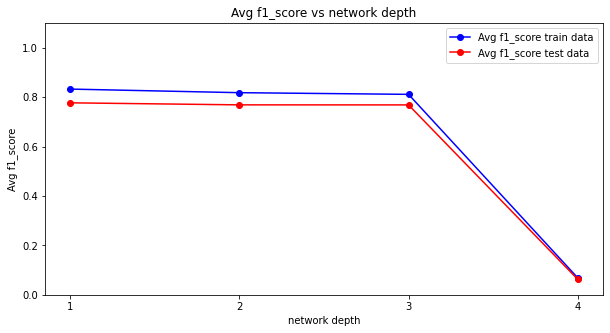

In [45]:
#Plot avg f1_scores for different depth
plt.figure(figsize=(10,5))
plt.plot(network_depth, f1_score_train, marker='o', markersize=6, color='blue', label='Avg f1_score train data')
plt.plot(network_depth, f1_score_test, marker='o', markersize=6, color='red', label='Avg f1_score test data')

plt.title('Avg f1_score vs network depth')
plt.xlabel('network depth')
plt.ylabel('Avg f1_score')
plt.xticks(network_depth)
plt.ylim(0,1.1)
plt.legend()
plt.show()

#### Adaptive learning

In [46]:
hidden_layers = [[512], [512,256], [512,256,128], [512,256,128,64]]
network_depth = [1,2,3,4]
f1_score_train = []
f1_score_test = []
for hidden_layer in hidden_layers:
    print(f"Hidden layer: {hidden_layer}")
    NN = NeuralNetwork(n = 1024, n_hidden_nodes = hidden_layer , r = 5, M = 32)
    NN.train(X_train, y_train_onehot, epoch_mode= False, activation="sigmoid", adaptive_learning = True, alpha = 0.01, stopping_threshold = 5.0e-06, printafter=50)
    y_pred_train, _ = NN.predict(X_train)
    y_pred_test, _ = NN.predict(X_test)
    
    print("accuracy on train data: ",accuracy_score(y_train_onehot, y_pred_train))
    print("metrics for train data: ")
    get_metric(y_train_onehot, y_pred_train)
    f1_score_train.append(f1_score(y_train_onehot, y_pred_train, average="macro"))
    
    print("accuracy on test data: ",accuracy_score(y_test_onehot, y_pred_test))
    print("metrics for test data: ")
    get_metric(y_test_onehot, y_pred_test)
    f1_score_test.append(f1_score(y_test_onehot, y_pred_test, average="macro"))
    
    print("\n")

Hidden layer: [512]
epoch 50
accuracy on train data:  0.701
learning rate:  0.001414213562373095
softmax loss:  2.4384530256167004e-05


epoch 100
accuracy on train data:  0.7294
learning rate:  0.001
softmax loss:  2.2590405138106635e-05


epoch 150
accuracy on train data:  0.7535
learning rate:  0.0008164965809277261
softmax loss:  2.4823077935786723e-05


epoch 200
accuracy on train data:  0.7701
learning rate:  0.0007071067811865475
softmax loss:  2.5202653816610038e-05


Convergence criteria satisfied!
epoch 201
accuracy on train data:  0.7705
learning rate:  0.0007053456158585983
softmax loss:  2.518159706339217e-05


accuracy on train data:  0.7705
metrics for train data: 
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2031
           1       0.81      0.83      0.82      1937
           2       0.65      0.70      0.68      1809
           3       0.57      0.62      0.59      1849
           4       0.85      0.75      0

/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


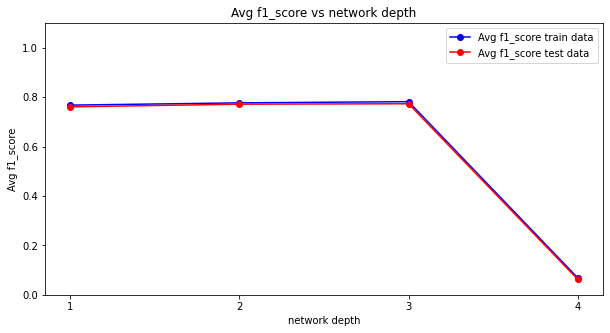

In [47]:
#Plot avg f1_scores for different depth
plt.figure(figsize=(10,5))
plt.plot(network_depth, f1_score_train, marker='o', markersize=6, color='blue', label='Avg f1_score train data')
plt.plot(network_depth, f1_score_test, marker='o', markersize=6, color='red', label='Avg f1_score test data')

plt.title('Avg f1_score vs network depth')
plt.xlabel('network depth')
plt.ylabel('Avg f1_score')
plt.xticks(network_depth)
plt.ylim(0,1.1)
plt.legend()
plt.show()

##### Relu activation function

In [48]:
hidden_layers = [[512], [512,256], [512,256,128], [512,256,128,64]]
network_depth = [1,2,3,4]
f1_score_train = []
f1_score_test = []
for hidden_layer in hidden_layers:
    print(f"Hidden layer: {hidden_layer}")
    NN = NeuralNetwork(n = 1024, n_hidden_nodes = hidden_layer , r = 5, M = 32)
    NN.train(X_train, y_train_onehot, epoch_mode= False, activation="relu", adaptive_learning = True, alpha = 0.01, stopping_threshold = 5.0e-06, printafter=50)
    y_pred_train, _ = NN.predict(X_train, activation="relu")
    y_pred_test, _ = NN.predict(X_test, activation="relu")
    
    print("accuracy on train data: ",accuracy_score(y_train_onehot, y_pred_train))
    print("metrics for train data: ")
    get_metric(y_train_onehot, y_pred_train)
    f1_score_train.append(f1_score(y_train_onehot, y_pred_train, average="macro"))
    
    print("accuracy on test data: ",accuracy_score(y_test_onehot, y_pred_test))
    print("metrics for test data: ")
    get_metric(y_test_onehot, y_pred_test)
    f1_score_test.append(f1_score(y_test_onehot, y_pred_test, average="macro"))
    
    print("\n")

Hidden layer: [512]
Convergence criteria satisfied!
epoch 6
accuracy on train data:  0.2091
learning rate:  0.004082482904638631
softmax loss:  0.00023208783009197323


accuracy on train data:  0.2091
metrics for train data: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.21      0.35     10000

   micro avg       0.21      0.21      0.21     10000
   macro avg       0.20      0.04      0.07     10000
weighted avg       1.00      0.21      0.35     10000
 samples avg       0.21      0.21      0.21     10000

accuracy on test data:  0.187
metrics for test data: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2  

/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Convergence criteria satisfied!
epoch 6
accuracy on train data:  0.2091
learning rate:  0.004082482904638631
softmax loss:  0.00023044619233218206


accuracy on train data:  0.2091
metrics for train data: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.21      0.35     10000

   micro avg       0.21      0.21      0.21     10000
   macro avg       0.20      0.04      0.07     10000
weighted avg       1.00      0.21      0.35     10000
 samples avg       0.21      0.21      0.21     10000

accuracy on test data:  0.187
metrics for test data: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00 

/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 50
accuracy on train data:  0.7289
learning rate:  0.001414213562373095
softmax loss:  3.145936113878991e-05


epoch 100
accuracy on train data:  0.7583
learning rate:  0.001
softmax loss:  3.272657747861718e-05


epoch 150
accuracy on train data:  0.7812
learning rate:  0.0008164965809277261
softmax loss:  1.1503443467968143e-05


epoch 200
accuracy on train data:  0.7962
learning rate:  0.0007071067811865475
softmax loss:  1.7943773712320744e-06


Convergence criteria satisfied!
epoch 201
accuracy on train data:  0.8045
learning rate:  0.0007053456158585983
softmax loss:  2.1482919875104044e-06


accuracy on train data:  0.8045
metrics for train data: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1966
           1       0.87      0.93      0.90      1845
           2       0.66      0.80      0.72      1624
           3       0.59      0.61      0.60      1932
           4       0.91      0.72      0.80      2633

   mi

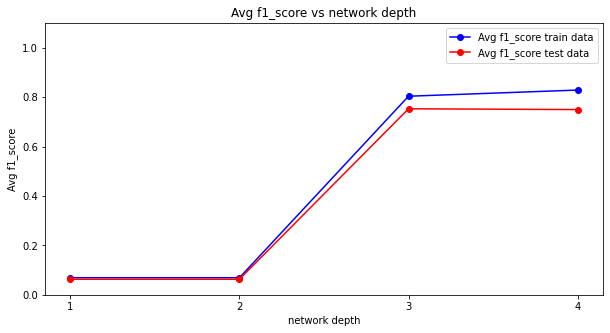

In [49]:
#Plot avg f1_scores for different depth
plt.figure(figsize=(10,5))
plt.plot(network_depth, f1_score_train, marker='o', markersize=6, color='blue', label='Avg f1_score train data')
plt.plot(network_depth, f1_score_test, marker='o', markersize=6, color='red', label='Avg f1_score test data')

plt.title('Avg f1_score vs network depth')
plt.xlabel('network depth')
plt.ylabel('Avg f1_score')
plt.xticks(network_depth)
plt.ylim(0,1.1)
plt.legend()
plt.show()

##### Relu activation function (with learning rate = 0.001)

In [6]:
hidden_layers = [[512], [512,256], [512,256,128], [512,256,128,64]]
network_depth = [1,2,3,4]
f1_score_train = []
f1_score_test = []
for hidden_layer in hidden_layers:
    print(f"Hidden layer: {hidden_layer}")
    NN = NeuralNetwork(n = 1024, n_hidden_nodes = hidden_layer , r = 5, M = 32)
    NN.train(X_train, y_train_onehot, epoch_mode= False, activation="relu", adaptive_learning = True, alpha = 0.001, stopping_threshold = 5.0e-06, printafter=50)
    y_pred_train, _ = NN.predict(X_train, activation="relu")
    y_pred_test, _ = NN.predict(X_test, activation="relu")
    
    print("accuracy on train data: ",accuracy_score(y_train_onehot, y_pred_train))
    print("metrics for train data: ")
    get_metric(y_train_onehot, y_pred_train)
    f1_score_train.append(f1_score(y_train_onehot, y_pred_train, average="macro"))
    
    print("accuracy on test data: ",accuracy_score(y_test_onehot, y_pred_test))
    print("metrics for test data: ")
    get_metric(y_test_onehot, y_pred_test)
    f1_score_test.append(f1_score(y_test_onehot, y_pred_test, average="macro"))
    
    print("\n")

Hidden layer: [512]
epoch 50
accuracy on train data:  0.6984
learning rate:  0.0001414213562373095
softmax loss:  3.2206525277455114e-05


epoch 100
accuracy on train data:  0.7177
learning rate:  0.0001
softmax loss:  2.8674372883269804e-05


epoch 150
accuracy on train data:  0.7355
learning rate:  8.164965809277261e-05
softmax loss:  2.6139527954960384e-05


epoch 200
accuracy on train data:  0.7488
learning rate:  7.071067811865475e-05
softmax loss:  2.3554841256167726e-05


Convergence criteria satisfied!
epoch 201
accuracy on train data:  0.7493
learning rate:  7.053456158585983e-05
softmax loss:  2.3523313554780805e-05


accuracy on train data:  0.7493
metrics for train data: 
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2050
           1       0.78      0.77      0.78      1990
           2       0.64      0.66      0.65      1904
           3       0.54      0.62      0.58      1748
           4       0.84      0.76   

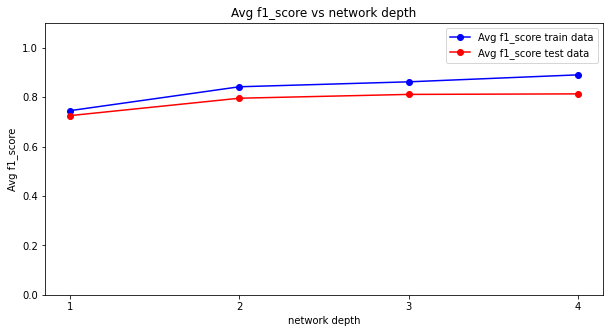

In [7]:
#Plot avg f1_scores for different depth
plt.figure(figsize=(10,5))
plt.plot(network_depth, f1_score_train, marker='o', markersize=6, color='blue', label='Avg f1_score train data')
plt.plot(network_depth, f1_score_test, marker='o', markersize=6, color='red', label='Avg f1_score test data')

plt.title('Avg f1_score vs network depth')
plt.xlabel('network depth')
plt.ylabel('Avg f1_score')
plt.xticks(network_depth)
plt.ylim(0,1.1)
plt.legend()
plt.show()

##### Neural Networks using scikit learn

In [19]:
hidden_layers = [[512], [512,256], [512,256,128], [512,256,128,64]]
network_depth = [1,2,3,4]
f1_score_train = []
f1_score_test = []
for hidden_layer in hidden_layers:
    print(f"Hidden layer: {hidden_layer}")
    clf = MLPClassifier(activation="relu", solver="sgd", alpha = 0, batch_size=32, hidden_layer_sizes=np.array(hidden_layer), learning_rate="invscaling", tol=5e-6, n_iter_no_change=5, verbose=True, learning_rate_init=0.01).fit(X_train, y_train_onehot)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    print("accuracy on train data: ",accuracy_score(y_train_onehot, y_pred_train))
    print("metrics for train data: ")
    get_metric(y_train_onehot, y_pred_train)
    f1_score_train.append(f1_score(y_train_onehot, y_pred_train, average="macro"))
    
    print("accuracy on test data: ",accuracy_score(y_test_onehot, y_pred_test))
    print("metrics for test data: ")
    get_metric(y_test_onehot, y_pred_test)
    f1_score_test.append(f1_score(y_test_onehot, y_pred_test, average="macro"))
    
    print("\n")

Hidden layer: [512]
Iteration 1, loss = 1.82100347
Iteration 2, loss = 1.71391782
Iteration 3, loss = 1.52315981
Iteration 4, loss = 1.51474497
Iteration 5, loss = 1.51029548
Iteration 6, loss = 1.50750493
Iteration 7, loss = 1.50565037
Iteration 8, loss = 1.50367111
Iteration 9, loss = 1.50203666
Iteration 10, loss = 1.50045418
Iteration 11, loss = 1.49933494
Iteration 12, loss = 1.49815999
Iteration 13, loss = 1.49698195
Iteration 14, loss = 1.49620743
Iteration 15, loss = 1.49550628
Iteration 16, loss = 1.49454919
Iteration 17, loss = 1.49363666
Iteration 18, loss = 1.49279152
Iteration 19, loss = 1.49200207
Iteration 20, loss = 1.49143824
Iteration 21, loss = 1.49060290
Iteration 22, loss = 1.48995872
Iteration 23, loss = 1.48938653
Iteration 24, loss = 1.48872835
Iteration 25, loss = 1.48810307
Iteration 26, loss = 1.48745704
Iteration 27, loss = 1.48675391
Iteration 28, loss = 1.48601222
Iteration 29, loss = 1.48555051
Iteration 30, loss = 1.48489258
Iteration 31, loss = 1.484429

/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


accuracy on train data:  0.3589
metrics for train data: 
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1990
           1       0.21      0.75      0.33       557
           2       0.03      0.58      0.07       117
           3       0.00      0.00      0.00         0
           4       0.66      0.73      0.69      1890

   micro avg       0.36      0.79      0.49      4554
   macro avg       0.36      0.59      0.39      4554
weighted avg       0.68      0.79      0.71      4554
 samples avg       0.36      0.36      0.36      4554

accuracy on test data:  0.363
metrics for test data: 
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       226
           1       0.20      0.71      0.31        56
           2       0.05      0.60      0.08        15
           3       0.00      0.00      0.00         0
           4       0.60      0.69      0.65       163

   micro avg       0

/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tkarthikeyan/.local/lib/python3.8/site-p

Iteration 1, loss = 1.75599291
Iteration 2, loss = 1.50284355
Iteration 3, loss = 1.39129507
Iteration 4, loss = 1.38382212
Iteration 5, loss = 1.37945388
Iteration 6, loss = 1.37674041
Iteration 7, loss = 1.37485859
Iteration 8, loss = 1.37307523
Iteration 9, loss = 1.37166307
Iteration 10, loss = 1.37024469
Iteration 11, loss = 1.36924451
Iteration 12, loss = 1.36834121
Iteration 13, loss = 1.36742281
Iteration 14, loss = 1.36596267
Iteration 15, loss = 1.36591150
Iteration 16, loss = 1.36515085
Iteration 17, loss = 1.36496215
Iteration 18, loss = 1.36400063
Iteration 19, loss = 1.36335653
Iteration 20, loss = 1.36291710
Iteration 21, loss = 1.36243440
Iteration 22, loss = 1.36167984
Iteration 23, loss = 1.36167079
Iteration 24, loss = 1.36108227
Iteration 25, loss = 1.36048485
Iteration 26, loss = 1.35995516
Iteration 27, loss = 1.35961524
Iteration 28, loss = 1.35919002
Iteration 29, loss = 1.35920701
Iteration 30, loss = 1.35863334
Iteration 31, loss = 1.35818692
Iteration 32, los

/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


accuracy on train data:  0.5267
metrics for train data: 
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      2008
           1       0.64      0.70      0.67      1806
           2       0.35      0.59      0.44      1168
           3       0.06      0.56      0.11       227
           4       0.68      0.73      0.70      1967

   micro avg       0.53      0.73      0.61      7176
   macro avg       0.53      0.69      0.56      7176
weighted avg       0.66      0.73      0.68      7176
 samples avg       0.53      0.53      0.53      7176

accuracy on test data:  0.521
metrics for test data: 
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       229
           1       0.62      0.69      0.65       178
           2       0.34      0.61      0.44       112
           3       0.06      0.50      0.11        22
           4       0.61      0.70      0.65       164

   micro avg       0

/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 1, loss = 1.76380936
Iteration 2, loss = 1.38822441
Iteration 3, loss = 1.37395561
Iteration 4, loss = 1.36949873
Iteration 5, loss = 1.36609622
Iteration 6, loss = 1.36384879
Iteration 7, loss = 1.36170042
Iteration 8, loss = 1.36104174
Iteration 9, loss = 1.35993561
Iteration 10, loss = 1.35869727
Iteration 11, loss = 1.35788140
Iteration 12, loss = 1.35715549
Iteration 13, loss = 1.35655835
Iteration 14, loss = 1.35555626
Iteration 15, loss = 1.35546035
Iteration 16, loss = 1.35481342
Iteration 17, loss = 1.35427231
Iteration 18, loss = 1.35355794
Iteration 19, loss = 1.35328877
Iteration 20, loss = 1.35279381
Iteration 21, loss = 1.35206872
Iteration 22, loss = 1.35187235
Iteration 23, loss = 1.35125906
Iteration 24, loss = 1.35109893
Iteration 25, loss = 1.35066431
Iteration 26, loss = 1.35031724
Iteration 27, loss = 1.34988212
Iteration 28, loss = 1.34967275
Iteration 29, loss = 1.34915685
Iteration 30, loss = 1.34871293
Iteration 31, loss = 1.34865636
Iteration 32, los

/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


accuracy on train data:  0.5642
metrics for train data: 
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1985
           1       0.67      0.70      0.68      1889
           2       0.42      0.59      0.49      1384
           3       0.14      0.54      0.23       531
           4       0.71      0.71      0.71      2067

   micro avg       0.56      0.72      0.63      7856
   macro avg       0.56      0.68      0.60      7856
weighted avg       0.65      0.72      0.68      7856
 samples avg       0.56      0.56      0.56      7856

accuracy on test data:  0.562
metrics for test data: 
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       225
           1       0.64      0.68      0.66       184
           2       0.40      0.61      0.48       130
           3       0.18      0.54      0.27        63
           4       0.63      0.68      0.66       173

   micro avg       0

/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 1, loss = 1.81368436
Iteration 2, loss = 1.44544842
Iteration 3, loss = 1.38917601
Iteration 4, loss = 1.38138721
Iteration 5, loss = 1.37689060
Iteration 6, loss = 1.37331294
Iteration 7, loss = 1.37047256
Iteration 8, loss = 1.36867094
Iteration 9, loss = 1.36701830
Iteration 10, loss = 1.36629762
Iteration 11, loss = 1.36428958
Iteration 12, loss = 1.36411254
Iteration 13, loss = 1.36277406
Iteration 14, loss = 1.36201276
Iteration 15, loss = 1.36122268
Iteration 16, loss = 1.36026491
Iteration 17, loss = 1.35992904
Iteration 18, loss = 1.35911954
Iteration 19, loss = 1.35855620
Iteration 20, loss = 1.35809020
Iteration 21, loss = 1.35724215
Iteration 22, loss = 1.35677803
Iteration 23, loss = 1.35652282
Iteration 24, loss = 1.35581300
Iteration 25, loss = 1.35539375
Iteration 26, loss = 1.35481140
Iteration 27, loss = 1.35403886
Iteration 28, loss = 1.35396309
Iteration 29, loss = 1.35331822
Iteration 30, loss = 1.35319095
Iteration 31, loss = 1.35287776
Iteration 32, los

/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


accuracy on train data:  0.5846
metrics for train data: 
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1997
           1       0.68      0.69      0.69      1958
           2       0.46      0.58      0.51      1568
           3       0.18      0.53      0.27       688
           4       0.71      0.71      0.71      2064

   micro avg       0.58      0.71      0.64      8275
   macro avg       0.58      0.68      0.61      8275
weighted avg       0.66      0.71      0.67      8275
 samples avg       0.58      0.58      0.58      8275

accuracy on test data:  0.581
metrics for test data: 
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       228
           1       0.66      0.68      0.67       194
           2       0.44      0.59      0.51       149
           3       0.20      0.45      0.28        85
           4       0.64      0.69      0.66       172

   micro avg       0

/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tkarthikeyan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


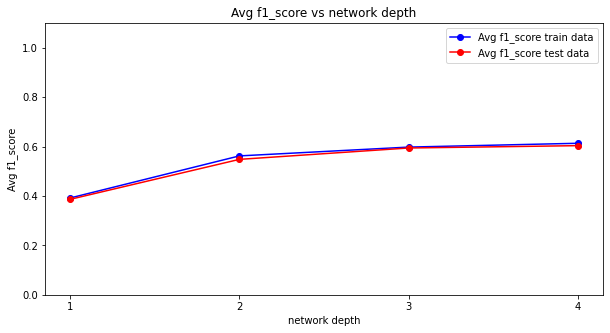

In [20]:
#Plot avg f1_scores for different depth
plt.figure(figsize=(10,5))
plt.plot(network_depth, f1_score_train, marker='o', markersize=6, color='blue', label='Avg f1_score train data')
plt.plot(network_depth, f1_score_test, marker='o', markersize=6, color='red', label='Avg f1_score test data')

plt.title('Avg f1_score vs network depth')
plt.xlabel('network depth')
plt.ylabel('Avg f1_score')
plt.xticks(network_depth)
plt.ylim(0,1.1)
plt.legend()
plt.show()